# Data

## Introduction
Light is what we see when the retina converts photons into spikes. Odors are what we smell when volatilised molecules are converted into spikes. Touch is what we feel when nerve endings turn tactile pressure into spikes. The brain trades in the global currency of the *spike*. 

If our end goal is to build a spiking neural network (SNN), it makes sense to use spikes at the input too. Although it is quite common to use non-spiking inputs, part of the appeal of encoding data come from the *three S's*: spikes, sparsity, and static suppression.



1.   **Spikes**: (a-b) Biological neurons process and communicate via spikes, which are electrical impulses of approximately 100 mV in amplitude. (c) Many computational models of neurons simplify this voltage burst to a discrete, single-bit event: a '1' or a '0'. This is far simpler to represent in hardware than a high precision value.

2.   **Sparsity**: (c) Neurons spend most of their time at rest, silencing most activations to *zero* at any given time. Not only are sparse vectors/tensors (with loads of zeros) cheap to store, but say we need to multiply sparse activations with synaptic weights. If most values are multiplied by '0', then we don't need to read many of the network parameters from memory. This means neuromorphic hardware can be extremely efficient. 

3.   **Static-Suppression (a.k.a, event-driven processing**: (d-e) The sensory periphery only processes information when there is new information to process. Each pixel in (e) responds to *changes* in illuminance, so most of the image is blocked out. Conventional signal processing requires all channels/pixels to adhere to a global sampling/shutter rate, which slows down how frequently sensing can take place. Event-driven processing now only contributes to sparsity and power-efficiency by blocking unchanging input, but it often allows for much faster processing speeds.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/3s.png?raw=true' width="600">
</center>

## Conversion to spike trains

### Istallations, imports & downloads

In [1]:
!pip install snntorch --quiet

     |████████████████████████████████| 92 kB 355 kB/s 


In [2]:
import torch
from torchvision import datasets, transforms
from snntorch import utils
from torch.utils.data import DataLoader

# Define a transformation done while converting images to tensors
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Download a dataset while applying a transformation
mnist_train = datasets.MNIST('/data/mnist', train=True, download=True, transform=transform)

# Take 1/10 subset of 60,000 images in the dataset
mnist_train = utils.data_subset(mnist_train, 10)
print(f"The size of mnist_train is {len(mnist_train)}")

# Create a dataloader that will load the data in chunks of the defined batch size
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw

The size of mnist_train is 6000


### Spike Encoding

Spiking Neural Networks (SNNs) are made to exploit time-varying data. And yet, MNIST is not a time-varying dataset.
There are two options for using MNIST with an SNN:

1. Repeatedly pass the same training sample to the network at each time step. This is like converting MNIST into a static, unchanging video.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_1_static.png?raw=true' width="700">
</center>

2. Convert the input into a spike train of sequence length `num_steps`, where each feature/pixel takes on a discrete value.
In this case, MNIST is converted into a time-varying sequence of spikes that features a relation to the original image.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true' width="700">
</center>

We will consider 3 types of data encoding:
1.   *Rate coding* uses input features to determine spiking **frequency**
2.   *Latency coding* uses input features to determine spike **timing**
3.   *Delta modulation* uses the temporal **change** of input features to generate spikes

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true' width="1000">
</center>

### Rate encoding

In [28]:
# Iterate through minibatches
inputs, targets  = next(iter(train_loader))
print(inputs.shape)
print(targets)

torch.Size([128, 1, 28, 28])
tensor([2, 4, 7, 2, 2, 8, 9, 6, 6, 1, 7, 0, 5, 5, 2, 2, 5, 7, 5, 5, 4, 3, 7, 2,
        0, 9, 4, 9, 7, 8, 0, 0, 6, 3, 1, 3, 6, 1, 5, 2, 3, 6, 1, 2, 0, 9, 4, 1,
        1, 1, 3, 2, 9, 7, 6, 9, 9, 0, 2, 6, 1, 4, 3, 2, 8, 0, 7, 8, 2, 2, 6, 0,
        8, 5, 8, 8, 2, 2, 7, 0, 5, 6, 3, 3, 4, 4, 2, 4, 6, 6, 8, 0, 4, 7, 7, 8,
        8, 9, 7, 6, 3, 3, 0, 0, 8, 6, 2, 7, 9, 1, 5, 9, 6, 0, 4, 2, 0, 3, 2, 7,
        8, 2, 9, 0, 9, 6, 9, 1])


In [29]:
print(inputs[0].shape) # One image of 128 images in the batch with one color channel
print(inputs[0][0].shape) # Image without color channel
print(inputs[0][0][0].shape) # One row with 28 pixel values of 28 rows in the image matrix

torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([28])


In [30]:
from snntorch import spikegen

spike_data = spikegen.rate(inputs, num_steps=10)
spike_data.shape

torch.Size([10, 128, 1, 28, 28])

In [31]:
print(spike_data[0].shape) # One time step of 128 images in the batch
print(spike_data[0][0].shape) # One image of 128 images in the batch with one color channel
print(spike_data[0][0][0].shape) # Image without color channel
print(spike_data[0][0][0][0].shape) # One row with 28 spikes of 28 rows in the image matrix

torch.Size([128, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([28])


In [32]:
# One raw from the image tensor
inputs[0][0][15]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3922, 0.8392,
        0.9725, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922,
        0.9922, 0.9922, 0.8196, 0.1765, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

In [33]:
# Raw converted into spike train using rate coding at time step 0
spike_data[0][0][0][15]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

torch.Size([10, 28, 28])


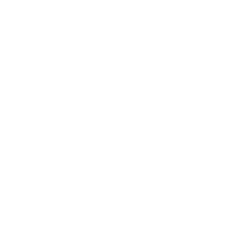

In [34]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

# Take one image rate-coded in 10 frames
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

# Create a grid
fig, ax = plt.subplots()

# Create animation of spikes
anim = splt.animator(spike_data_sample, fig, ax)

# Show the video of animation
HTML(anim.to_html5_video())

torch.Size([10, 28, 28])


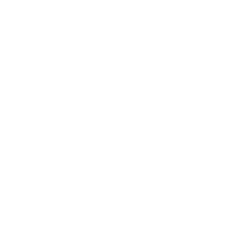

In [41]:
# Reduce the rate density
spike_data_sparse = spikegen.rate(inputs, num_steps=10, gain=0.25)

# Take one image rate-coded in 10 frames
spike_data_sample_sparse = spike_data_sparse[:, 0, 0]
print(spike_data_sample_sparse.size())

# Create a grid
fig, ax = plt.subplots()

# Create animation of spikes
anim = splt.animator(spike_data_sample_sparse, fig, ax)

# Show the video of animation
HTML(anim.to_html5_video())

torch.Size([10, 784])


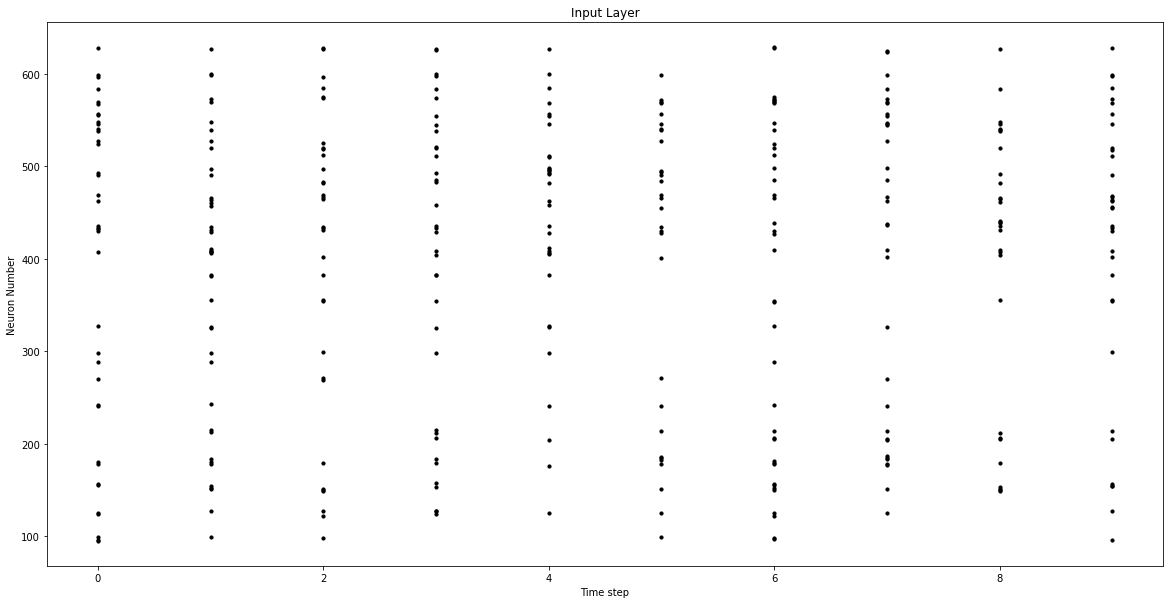

In [42]:
# Create a raster plot of spikes - requires reshaping to 2-dimensional tensor, thus we multiply 1x28x28 to receive 784 vectors with spikes for 10 frames 

# Reshape
spike_data_sample_raster = spike_data_sample_sparse.reshape((10, -1))
print(spike_data_sample_raster.shape)

# Define plot to show
fig = plt.figure(facecolor="w", figsize=(20, 10))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample_raster, ax, s=10, c="black")

# Create labels and show
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [44]:
# Find one single neuron from 784 that spikes and index into it

idx = 585
neuron = spike_data_sample_raster[:,idx]

print(neuron.shape)
print(neuron)

torch.Size([10])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 1.])


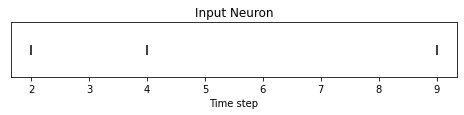

In [45]:
# Visualize a spiking neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(neuron, ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

### Latency encoding

Some of the arguments include:

* `tau`: speed of firing - a higher ``tau`` will induce slower firing.
* `threshold`: the membrane potential firing threshold - all values below the threshold are clipped and assigned to the final time step.

In [46]:
spike_data = spikegen.latency(inputs, num_steps=100, tau=5, threshold=0.01)
spike_data.shape

torch.Size([100, 128, 1, 28, 28])

torch.Size([100, 28, 28])


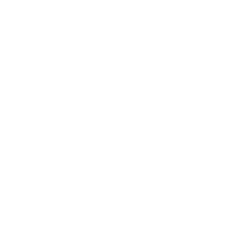

In [47]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

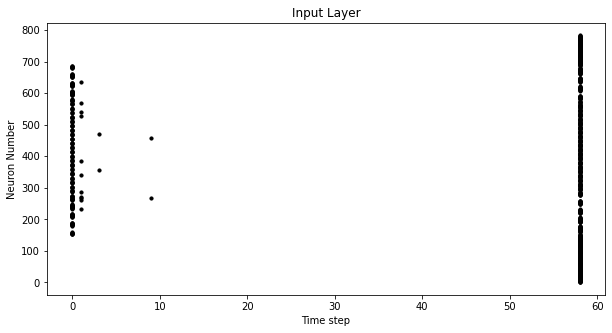

In [ ]:
# Raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].reshape((100, -1)), ax, s=10, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

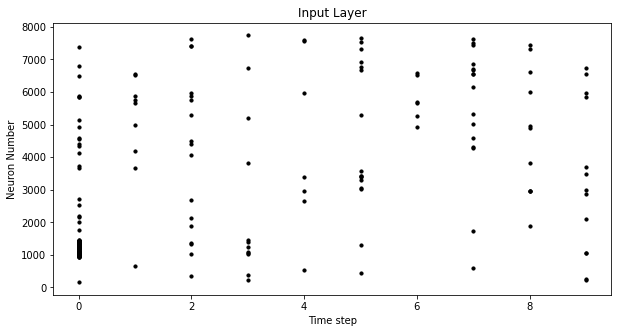

In [ ]:
# Add normalization, linerialization and clipping to smooth the plot

spike_data_smooth = spikegen.latency(inputs, num_steps=100, tau=5, threshold=0.01, 
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_smooth[:, 0].reshape((10, -1)), ax, s=10, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

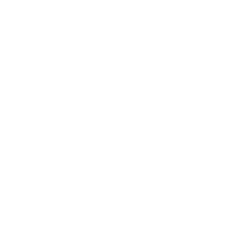

In [ ]:
spike_data_sample_smooth = spike_data_smooth[:, 0, 0]

fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample_smooth, fig, ax)

HTML(anim.to_html5_video())

### Delta modulation
Delta modulation is based on event-driven spiking. The `snntorch.delta` function accepts a time-series tensor as input. It takes the difference between each subsequent feature across all time steps. By default, if the difference is both positive and greater than the threshold, a spike is generated:



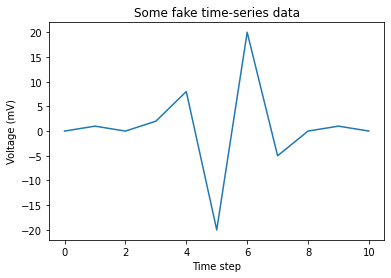

In [ ]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

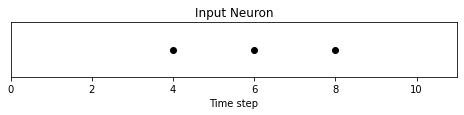

In [ ]:
# Convert data
spike_data = spikegen.delta(data, threshold=4)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

There are three time steps where the difference between $data[T]$ and $data[T+1]$ is greater than or equal to $V_{thr}=4$. This means there are three *on-spikes*. 

The large dip to $-20$ has not been captured above. If negative swings have importance in your data, you can enable the optional argument `off_spike=True`.

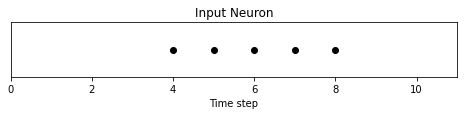

In [ ]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

Let's convert an image using delta modulation. Here is what documention says:
* `data` (torch.Tensor) – Data tensor for a single batch of shape `[num_steps x batch x input_size]`

* `threshold` – Input features with a change greater than the thresold across one timestep will generate a spike, defaults to 0.1

In [ ]:
# Download test set without transform applied
mnist_test = datasets.MNIST('/data/mnist', train=False, download=True)

print(len(mnist_test)) # test set length
print(len(mnist_test[0])) # One image with a label - a tuple of the length 2
print(mnist_test[0][1]) # Label of the first image
mnist_test[0][0] # First image itself

10000
2
7


In [ ]:
from PIL import Image

rotated_image = []
image_tensors = []
reshaped = []
for i in range(5):
    image = mnist_test[0][0].rotate(10*i)
    rotated_image.append(image)
    image_tensor = transform(image)
    image_tensors.append(image_tensor)
    image_reshaped = image_tensor.reshape(-1)
    reshaped.append(image_reshaped)

print(image_tensors[4].shape)
print(reshaped[4].shape)
rotated_image[4]

torch.Size([1, 28, 28])
torch.Size([784])


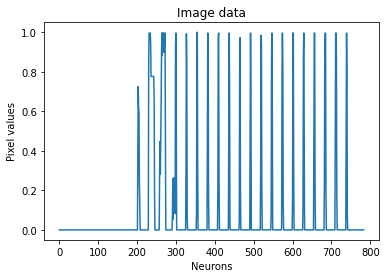

In [ ]:
# Plot the tensor
plt.plot(reshaped[0])

plt.title("Image data")
plt.xlabel("Neurons")
plt.ylabel("Pixel values")
plt.show()

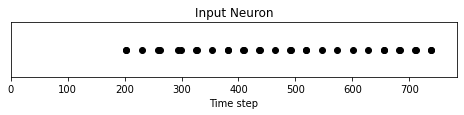

In [ ]:
# Convert data
spike_data = spikegen.delta(reshaped[0], threshold=0.2)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(reshaped[0]))
plt.show()

torch.Size([784])


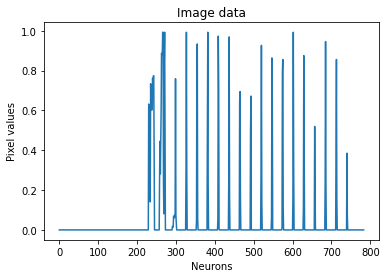

In [ ]:
result = reshaped[0] * reshaped[1]
print(result.shape)

plt.plot(result)

plt.title("Image data")
plt.xlabel("Neurons")
plt.ylabel("Pixel values")
plt.show()

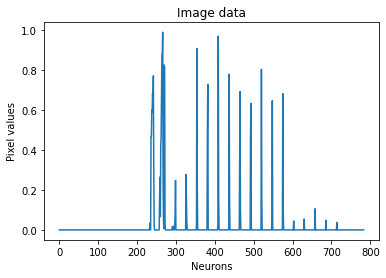

In [ ]:
result3 = reshaped[0] * reshaped[1] * reshaped[2]

plt.plot(result3)

plt.title("Image data")
plt.xlabel("Neurons")
plt.ylabel("Pixel values")
plt.show()

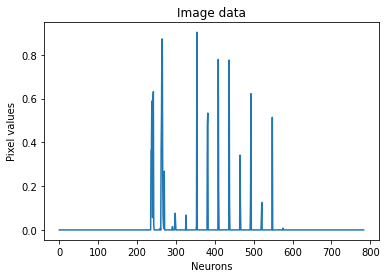

In [ ]:
result4 = reshaped[0] * reshaped[1] * reshaped[2] * reshaped[3]

plt.plot(result4)

plt.title("Image data")
plt.xlabel("Neurons")
plt.ylabel("Pixel values")
plt.show()

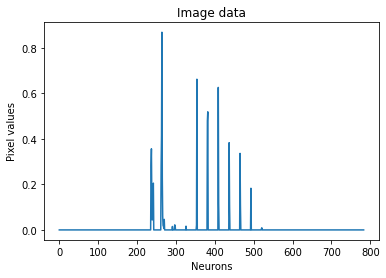

In [ ]:
result5 = reshaped[0] * reshaped[1] * reshaped[2] * reshaped[3] * reshaped[4]

plt.plot(result5)

plt.title("Image data")
plt.xlabel("Neurons")
plt.ylabel("Pixel values")
plt.show()

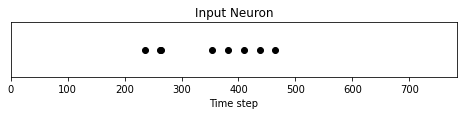

In [ ]:
# Convert data
spike_data = spikegen.delta(result5, threshold=0.2)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(result5))
plt.show()

## Loading neuromorphic dataset

Loading datasets from neuromorphic sensors is made super simple thanks to [Tonic](https://github.com/neuromorphs/tonic), which works much like PyTorch vision.

Let's start by loading the neuromorphic version of the MNIST dataset, called [N-MNIST](https://tonic.readthedocs.io/en/latest/reference/datasets.html#n-mnist). We can have a look at some raw events to get a feel for what we're working with.

In [ ]:
!pip install tonic

In [3]:
import tonic
import torch
from torch.utils.data import DataLoader

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]
print(target)
print(len(events))
print(events)

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST
1
2723
[(24, 10,    105, 1) (13, 12,   6115, 1) ( 1, 13,   6149, 0) ...
 (19, 18, 301991, 1) (12,  7, 305136, 1) (32, 23, 308710, 1)]


Each row corresponds to a single event, which consists of four parameters: (*x-coordinate, y-coordinate, timestamp, polarity*).

* x & y co-ordinates correspond to an address in a $34 \times 34$ grid.

* The timestamp of the event is recorded in microseconds.

* The polarity refers to whether an on-spike (+1) or an off-spike (-1) occured; i.e., an increase in brightness or a decrease in brightness.

If we were to accumulate those events over time and plot the bins as images, it looks like this:

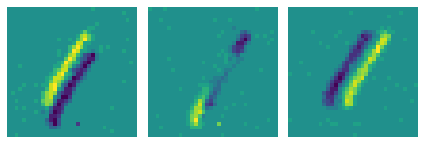

In [4]:
tonic.utils.plot_event_grid(events)

However, neural nets don't take lists of events as input. The raw data must be converted into a suitable representation, such as a tensor. We can choose a set of transforms to apply to our data before feeding it to our network. The neuromorphic camera sensor has a temporal resolution of microseconds, which when converted into a dense representation, ends up as a very large tensor. That is why we bin events into a smaller number of frames using the [ToFrame transformation](https://tonic.readthedocs.io/en/latest/reference/transformations.html#frames), which reduces temporal precision but also allows us to work with it in a dense format.

* `time_window=1000` integrates events into 1000$~\mu$s bins

* Denoise removes isolated, one-off events. If no event occurs within a neighbourhood of 1 pixel across `filter_time` microseconds, the event is filtered. Smaller `filter_time` will filter more events.

In [5]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size
print(sensor_size)

# Denoise removes isolated, one-off events
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000), 
                                      transforms.ToFrame(sensor_size=sensor_size, 
                                                         time_window=1000)
                                     ])

train_set = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
#test_set = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)

(34, 34, 2)


In [6]:
# Explore the data shape after conversion to tensors
input, label = next(iter(train_set))
print(input.shape)
print(label)

(301, 2, 34, 34)
1


In [7]:
# Decompose
print(input[244].shape) # timestep
print(input[244][1].shape) # polarity
print(input[244][0][12].shape) # one row of the tensor image
print(input[244][0][12])

(2, 34, 34)
(34, 34)
(34,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
# Let's find where th spikes occur
for i in range(34):
    print(input[244][0][i])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0

The original data is stored in a format that is slow to read. To speed up dataloading, we can make use of disk caching. That means that once files are loaded from the original file, they are written to disk in an efficient format in our cache directory. 

We can decrease the time it takes to read 100 samples by using a PyTorch DataLoader in addition to disk caching.

In [10]:
from tonic import CachedDataset

cached_train_set = CachedDataset(train_set, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_train_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: CachedDataset is deprecated and will be removed in a future release. It currently points to DiskCachedDataset to distinguish it from MemoryCachedDataset. Documentation available under https://tonic.readthedocs.io/en/latest/reference/data_classes.html#caching
  This is separate from the ipykernel package so we can avoid doing imports until


Now that we've reduced our loading time, we also want to use batching to make efficient use of the GPU. 

Because event recordings have different lengths, we are going to provide a  collation function `tonic.collation.PadTensors()` that will pad out shorter recordings to ensure all samples in a batch have the same dimensions. 

In [11]:
batch_size = 128
trainloader = DataLoader(cached_train_set, batch_size=batch_size, shuffle=True, collate_fn=tonic.collation.PadTensors())

# Leaky integrate-and-fire (LIF) neuron

In our brains, a neuron might be connected to 1,000 $-$ 10,000 other neurons. If one neuron spikes, all downhill neurons might feel it. But what determines whether a neuron spikes in the first place? The past century of experiments demonstrate that if a neuron experiences *sufficient* stimulus at its input, then it might become excited and fire its own spike. 

Where does this stimulus come from? It could be from:
* the sensory periphery, 
* an invasive electrode artificially stimulating the neuron, or in most cases,
* from other pre-synaptic neurons. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_2_intuition.png?raw=true' width="500">
</center>

# Membrane
Like all cells, a neuron is surrounded by a thin membrane. This membrane is a lipid bilayer that insulates the conductive saline solution within the neuron from the extracellular medium. Electrically, the two conductive solutions separated by an insulator act as a capacitor. 

Another function of this membrane is to control what goes in and out of this cell (e.g., ions such as Na$^+$). The membrane is usually impermeable to ions which blocks them from entering and exiting the neuron body. But there are specific channels in the membrane that are triggered to open by injecting current into the neuron. This charge movement is electrically modelled by a resistor.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_3_passivemembrane.png?raw=true' width="450">
</center>

A large variety of neuron models are out there, ranging from biophysically accurate models (i.e., the Hodgkin-Huxley models) to the extremely simple artificial neuron that pervades all facets of modern deep learning.

**Hodgkin-Huxley Neuron Models**$-$While biophysical models can reproduce electrophysiological results with a high degree of accuracy, their complexity makes them difficult to use at present.

**Artificial Neuron Model**$-$On the other end of the spectrum is the artificial neuron. The inputs are multiplied by their corresponding weights and passed through an activation function. This simplification has enabled deep learning researchers to perform incredible feats in computer vision, natural language processing, and many other machine learning-domain tasks.

**Leaky Integrate-and-Fire Neuron Models**$-$Somewhere in the middle of the divide lies the leaky integrate-and-fire (LIF) neuron model. It takes the sum of weighted inputs, much like the artificial neuron. But rather than passing it directly to an activation function, it will integrate the input over time with a leakage, much like an RC circuit. If the integrated value exceeds a threshold, then the LIF neuron will emit a voltage spike. The LIF neuron abstracts away the shape and profile of the output spike; it is simply treated as a discrete event. As a result, information is not stored within the spike, but rather the timing (or frequency) of spikes. Simple spiking neuron models have produced much insight into the neural code, memory, network dynamics, and more recently, deep learning. The LIF neuron sits in the sweet spot between biological plausibility and practicality. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_1_neuronmodels.png?raw=true' width="1000">
</center>


## Spiking mechanism anatomy

### Create a single spike train
Let's start with creation of a dummy spike train of dimension time x batch_size x features

In [12]:
from snntorch import spikegen

spk_in = spikegen.rate_conv(torch.rand((25, 784)))
spk_in = spk_in.unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")
spk_in

Dimensions of spk_in: torch.Size([25, 1, 784])


tensor([[[0., 0., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 0.]],

        ...,

        [[0., 1., 0.,  ..., 1., 1., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 1.]]])

### Simulate a forward pass

Recall that if the membrane exceeds the threshold, then the neuron emits an output spike: 

$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{0}$$

If a spike is triggered, the membrane potential should be reset. The *reset-by-subtraction* mechanism is modeled by:

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{S[t]U_{\rm thr}}_\text{reset} \tag{1}$$

As $W$ is a learnable parameter, and $U_{\rm thr}$ is often just set to $1$ (though can be tuned), this leaves the decay rate $\beta$ as the only hyperparameter left to be specified.

In [13]:
import torch.nn as nn
import snntorch as snn

# Layer parameters
num_inputs = 1*28*28 #=784
num_hidden = 1000
num_outputs = 10
beta = 0.99 # membrane decay rate
num_steps = 25

# Initialize layers
linear1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
linear2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

print("Initialized membrane 1:", mem1)
print("Initialized membrane 2:", mem2)

# Create empty lists to record outputs
mem1_rec = []
mem2_rec = []
spk1_rec = []
spk2_rec = []

# Forward pass simulation
for step in range(num_steps):
    #print(spk_in[0])

    post_synaptic_current1 = linear1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    #print(post_synaptic_current1)

    spk1, mem1 = lif1(post_synaptic_current1, mem1) # mem[t+1] <--post-synaptic current + decayed membrane
    #print(spk1)

    post_synaptic_current2 = linear2(spk1)
    #print(post_synaptic_current2)

    spk2, mem2 = lif2(post_synaptic_current2, mem2)
    #print(spk2)

    mem1_rec.append(mem1)
    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

Initialized membrane 1: tensor([])
Initialized membrane 2: tensor([])


In [14]:
# Classification output
print("Membrane potential output", mem2_rec[8]) # 10 variables corresponding to each class probability
print("Spiking output", spk2_rec[8])

Membrane potential output tensor([[-1.5051,  0.3149, -0.4412, -0.3396,  0.9999,  0.4553, -0.7074, -1.1393,
         -0.0717, -0.5748]], grad_fn=<SubBackward0>)
Spiking output tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<HeavisideBackward>)


In [ ]:
# Membrane potential hidden state
mem1_rec[24]

In [ ]:
# Spiking hidden state
spk1_rec[24]

### Simple spiking net definition
In this section, we will create a 2-layer fully-connected neural network. Compared to our simulations so far, each neuron will now integrate over many more incoming input spikes.

In [17]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.linear1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.linear2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            # record outputs
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = Net().to(device)

In [18]:
# Perform a single forward pass
net.train()
spk_rec, mem_rec = net(spk_in)

print(spk_rec[24])
print(mem_rec[24])

tensor([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]], grad_fn=<SelectBackward0>)
tensor([[-2.8468,  1.1411, -1.1699, -1.4822,  1.0962, -0.8985, -2.0594, -2.9814,
          0.5819,  0.0294]], grad_fn=<SelectBackward0>)


### Calculate the loss using membare potential

In [19]:
# Initialize the loss object
loss = nn.CrossEntropyLoss()

# Initialize the total loss value
loss_val = torch.zeros((1), dtype=torch.float, device=device)

# Fake the target to calculate the loss
target = torch.tensor([1])

# Sum the loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], target)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 40.715


### Calculate the loss using spikes
The approach below uses the Mean Square Error Spike Count Loss, which aims to elicit spikes from the correct class 80% of the time, and 20% of the time from incorrect classes. Encouraging incorrect neurons to fire could be motivated to avoid dead neurons.

In [20]:
from snntorch import functional as SF

# Initialize the loss object
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# Initialize the total loss value
loss_val = torch.zeros((1), dtype=torch.float, device=device)

# Fake the target to calculate the loss
target = torch.tensor([1])

# Sum the loss at every step
for step in range(num_steps):
  loss_val += loss(spk_rec[step], target)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 55.402


# Train a simple spiking neural network (SNN)

By default, PyTorch’s autodifferentiation mechanism in `torch.autograd` nulls the gradient signal of the spiking neuron graph due to non-differentiable spiking threshold functions. snntorch overrides the default gradient by using `snntorch.neurons.Heaviside`.

Alternative gradients are also available in the `snntorch.surrogate` module. These represent either approximations of the backward pass or probabilistic models of firing as a function of the membrane potential.


<center>
<img src='https://tonic.readthedocs.io/en/latest/_images/surrogates.png?raw=true' width="450">
</center>

The surrogate gradient must be passed as the `spike_grad` argument to the neuron model. If `spike_grad` is left unspecified, it defaults to `snntorch.neurons.Heaviside`.

One of the surrogate gradients of the Heaviside step function is [`fast_sigmoid`](https://snntorch.readthedocs.io/en/latest/snntorch.surrogate.html#snntorch.surrogate.FastSigmoid).
 
The slope defaults to 25, but can be modified by calling `surrogate.fast_sigmoid(slope=25)`.

In [22]:
# Data shape reminder
inputs, targets = next(iter(trainloader))
print(inputs.shape)
print(targets)

torch.Size([128, 313, 2, 34, 34])
tensor([7, 6, 5, 4, 1, 6, 9, 5, 5, 3, 1, 9, 2, 0, 8, 2, 8, 6, 4, 3, 8, 8, 1, 8,
        4, 7, 1, 1, 6, 1, 7, 3, 8, 4, 3, 2, 1, 3, 2, 3, 6, 8, 1, 8, 6, 7, 8, 8,
        4, 2, 9, 3, 4, 5, 6, 8, 2, 5, 4, 3, 5, 4, 1, 4, 9, 6, 1, 8, 3, 5, 7, 7,
        9, 9, 1, 1, 1, 2, 5, 3, 1, 7, 5, 0, 3, 6, 4, 2, 9, 0, 6, 5, 5, 6, 1, 7,
        4, 7, 1, 7, 3, 0, 3, 5, 6, 9, 4, 0, 4, 2, 6, 2, 2, 2, 1, 4, 3, 2, 3, 4,
        0, 2, 8, 5, 5, 1, 4, 0])


In [24]:
# Size of the N-MNIST
len(trainloader) # 469 batches of 128 images each = 60 032 images

469

In [25]:
# SNN input shape 
inputs[:, 0].view(batch_size, -1).shape # one time step from 311 

torch.Size([128, 2312])

In [73]:
# Define the SNN architecture
 
from snntorch import surrogate

num_inputs = 2*34*34
num_hidden = 1000
num_outputs = 10

# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=75)
beta = 0.5

#  Initialize Network using Sequential API
sn_net = nn.Sequential(
                    nn.Linear(num_inputs, num_hidden),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Linear(num_hidden, num_outputs),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

def forward_pass(sn_net, data):  
  spk_rec = []
  utils.reset(sn_net)  # resets hidden states for all LIF neurons in sn_net

  for step in range(data.size(1)):  # data.size(1) = number of time steps
        spk_out, mem_out = sn_net(data[:, step].view(batch_size, -1))
        spk_rec.append(spk_out)
  
  return torch.stack(spk_rec)

In [74]:
# Params

optimizer = torch.optim.Adam(sn_net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

num_epochs = 1
num_iters = 100 # Only 100 batches of data will be treated: 128x100 = 1280 images

loss_hist = []
acc_hist = []

# Training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        
        # Send the data to device
        data = data.to(device)
        targets = targets.to(device)
        print("Input shape", data.shape)

        # Put the model into a train mode (gradints will be calculated)
        sn_net.train()

        # Perform a forward pass
        spk_rec = forward_pass(sn_net, data)
        print("Output", spk_rec.shape)

        # Calculate the loss over entire batch
        loss_val = loss_fn(spk_rec, targets)

        # Clear previously stored gradients
        optimizer.zero_grad()

        # Calculate gradients
        loss_val.backward()

        # Update the weights
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
 
        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets) 
        acc_hist.append(acc)
        
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # This will end training after 50 iterations by default
        if i == num_iters:
          break

torch.Size([128, 310, 2, 34, 34])
Epoch 0, Iteration 0 
Train Loss: 31.00
Accuracy: 5.47%

torch.Size([128, 309, 2, 34, 34])
Epoch 0, Iteration 1 
Train Loss: 30.58
Accuracy: 8.59%

torch.Size([128, 310, 2, 34, 34])
Epoch 0, Iteration 2 
Train Loss: 30.97
Accuracy: 11.72%

torch.Size([128, 311, 2, 34, 34])
Epoch 0, Iteration 3 
Train Loss: 17.34
Accuracy: 8.59%

torch.Size([128, 313, 2, 34, 34])
Epoch 0, Iteration 4 
Train Loss: 17.35
Accuracy: 12.50%

torch.Size([128, 311, 2, 34, 34])
Epoch 0, Iteration 5 
Train Loss: 18.83
Accuracy: 8.59%

torch.Size([128, 310, 2, 34, 34])
Epoch 0, Iteration 6 
Train Loss: 15.01
Accuracy: 10.94%

torch.Size([128, 310, 2, 34, 34])
Epoch 0, Iteration 7 
Train Loss: 19.40
Accuracy: 28.91%

torch.Size([128, 311, 2, 34, 34])
Epoch 0, Iteration 8 
Train Loss: 13.44
Accuracy: 9.38%

torch.Size([128, 310, 2, 34, 34])
Epoch 0, Iteration 9 
Train Loss: 14.24
Accuracy: 10.94%

torch.Size([128, 312, 2, 34, 34])
Epoch 0, Iteration 10 
Train Loss: 12.15
Accuracy: 

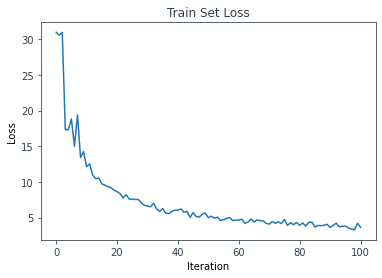

In [75]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

# Plot the loss
fig = plt.figure(facecolor="w")
plt.plot(loss_hist)
plt.title("Train Set Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

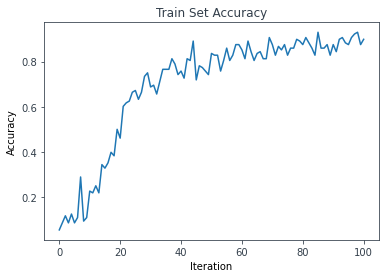

In [76]:
# Plot accuracy
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

The target label is: 1


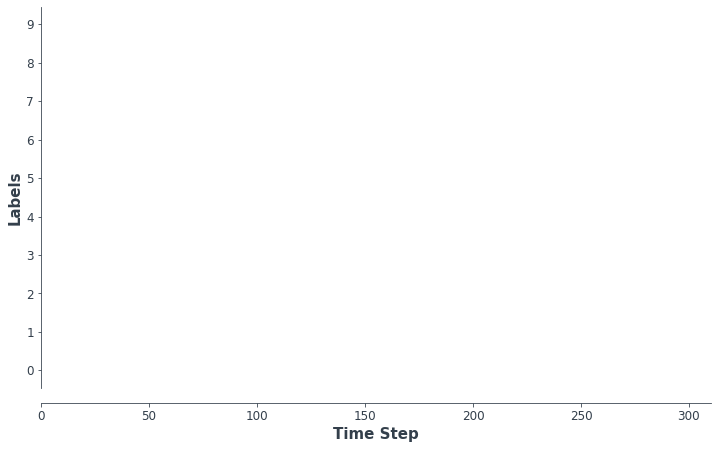

In [77]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels, 
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())

# Train a convolutional spiking neural network (CSNN)

In [78]:
# Define the CSNN architecture

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=75)
beta = 0.5

#  Initialize Network
csn_net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

def forward_pass(csn_net, data):  
  spk_rec = []
  utils.reset(csn_net)  # resets hidden states for all LIF neurons in csn_net

  for step in range(data.size(1)):  # data.size(1) = number of time steps
      spk_out, mem_out = csn_net(data[:, step])
      spk_rec.append(spk_out)
  
  return torch.stack(spk_rec)

In [79]:
# Params
optimizer = torch.optim.Adam(csn_net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

num_epochs = 1
num_iters = 100

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        csn_net.train()
        spk_rec = forward_pass(csn_net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
 
        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets) 
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # This will end training after 50 iterations by default
        if i == num_iters:
          break

Epoch 0, Iteration 0 
Train Loss: 30.96
Accuracy: 12.50%

Epoch 0, Iteration 1 
Train Loss: 31.08
Accuracy: 3.12%

Epoch 0, Iteration 2 
Train Loss: 31.00
Accuracy: 6.25%

Epoch 0, Iteration 3 
Train Loss: 31.00
Accuracy: 15.62%

Epoch 0, Iteration 4 
Train Loss: 30.90
Accuracy: 10.16%

Epoch 0, Iteration 5 
Train Loss: 30.96
Accuracy: 10.94%

Epoch 0, Iteration 6 
Train Loss: 31.00
Accuracy: 12.50%

Epoch 0, Iteration 7 
Train Loss: 30.90
Accuracy: 11.72%

Epoch 0, Iteration 8 
Train Loss: 31.00
Accuracy: 9.38%

Epoch 0, Iteration 9 
Train Loss: 31.02
Accuracy: 10.94%

Epoch 0, Iteration 10 
Train Loss: 31.02
Accuracy: 12.50%

Epoch 0, Iteration 11 
Train Loss: 30.90
Accuracy: 11.72%

Epoch 0, Iteration 12 
Train Loss: 30.90
Accuracy: 16.41%

Epoch 0, Iteration 13 
Train Loss: 30.90
Accuracy: 9.38%

Epoch 0, Iteration 14 
Train Loss: 30.80
Accuracy: 7.81%

Epoch 0, Iteration 15 
Train Loss: 24.74
Accuracy: 7.03%

Epoch 0, Iteration 16 
Train Loss: 15.58
Accuracy: 7.03%

Epoch 0, Itera

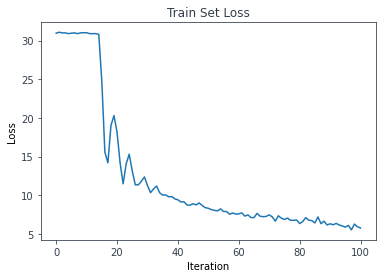

In [80]:
import matplotlib.pyplot as plt

# Plot loss
fig = plt.figure(facecolor="w")
plt.plot(loss_hist)
plt.title("Train Set Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

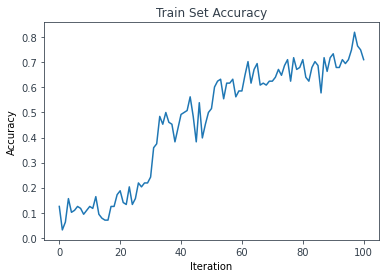

In [81]:
# Plot accuracy
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

The target label is: 2


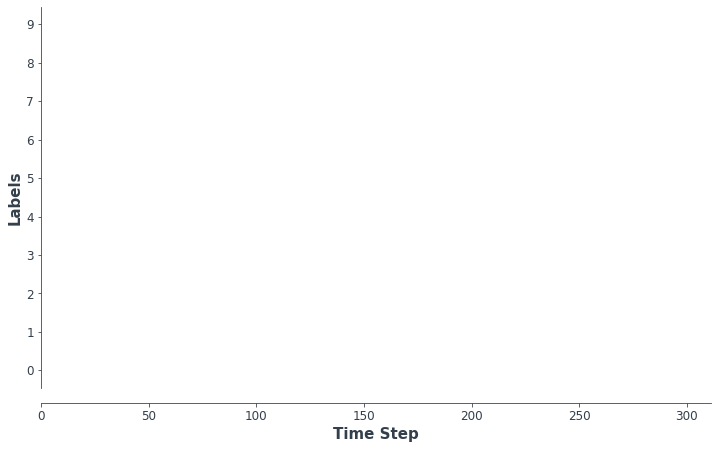

In [82]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels, 
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())

# Visualize learned weights

In [83]:
# Get all the model children as list
model_children = list(csn_net.children())

model_weights = []
conv_layers = []

# Append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
        
print(f"Total convolutional layers: {len(conv_layers)}")
print(f"Weights shape for the 1st conv layer: {model_weights[0].shape}")
print(f"Weights shape for the 2nd conv layer: {model_weights[1].shape}")

Total convolutional layers: 2
Weights shape for the 1st conv layer: torch.Size([12, 2, 5, 5])
Weights shape for the 2nd conv layer: torch.Size([32, 12, 5, 5])


In [84]:
first_conv_layer = model_weights[0]
print(len(first_conv_layer)) # 12 filters
print(first_conv_layer[0].shape) # 5x5 filter matrices for 2 polarities

12
torch.Size([2, 5, 5])


In [85]:
print(first_conv_layer[0][0].size())
first_conv_layer[0][0]

torch.Size([5, 5])


tensor([[-0.0772, -0.0587,  0.0666,  0.0419, -0.1408],
        [ 0.0432,  0.0499, -0.0827, -0.1347, -0.0007],
        [-0.1702, -0.1093,  0.0930,  0.0708,  0.0315],
        [ 0.0686,  0.0694,  0.1084,  0.1094, -0.0344],
        [ 0.0062, -0.1568, -0.0386,  0.0390, -0.1422]],
       grad_fn=<SelectBackward0>)

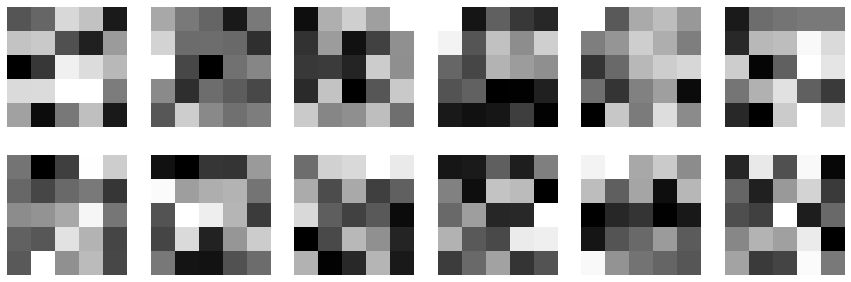

In [86]:
# Visualize filters of the 1st conv layer
plt.figure(figsize=(15, 5))
for i, filter in enumerate(first_conv_layer): # iterate through 12 filters
    plt.subplot(2, 6, i+1)
    plt.imshow(filter[0, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('../filter.png')
plt.show()

In [87]:
second_conv_layer = model_weights[1]
print(len(second_conv_layer)) # 32 filters
print(second_conv_layer[0].shape)

32
torch.Size([12, 5, 5])


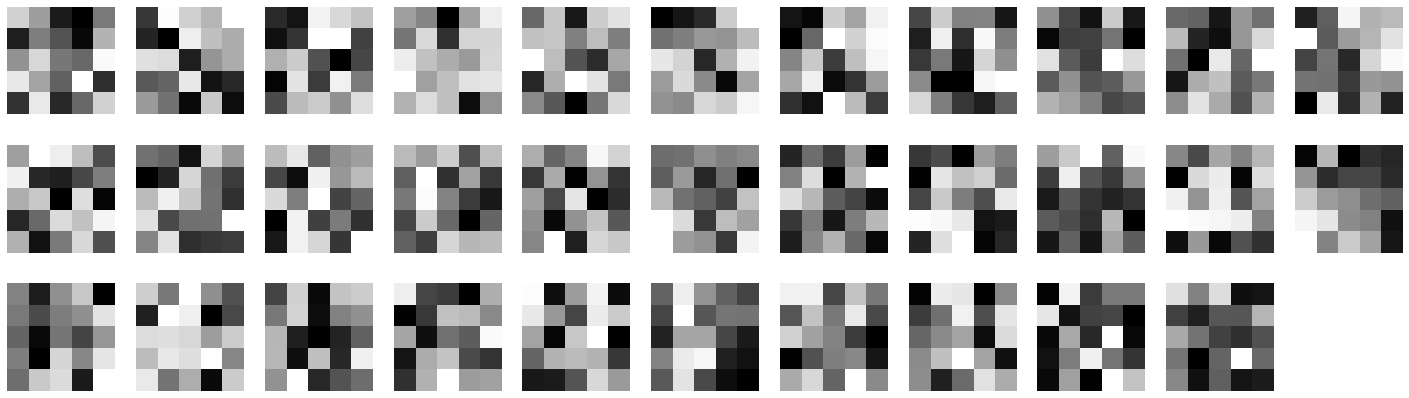

In [88]:
# Visualize filters of the 2nd conv layer
plt.figure(figsize=(25, 25))
for i, filter in enumerate(second_conv_layer): # iterate through 12 filters
    plt.subplot(10, 11, i+1)
    plt.imshow(filter[1, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('../filter.png')
plt.show()

# Ressources
1. https://snntorch.readthedocs.io/en/latest/tutorials/index.html
2. https://tonic.readthedocs.io/en/latest/
3. https://github.com/Shikhargupta/Spiking-Neural-Network 